In [0]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms, datasets

In [0]:
train = datasets.MNIST('', train = True, download = True,
                       transform = transforms.Compose([transforms.ToTensor()]))
train_set = torch.utils.data.DataLoader(train, batch_size = 100, shuffle = True)

In [30]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("Running on cpu")

Tesla P4


In [0]:
def latent_space_vectors(size): #size is the number of samples in a batch
    return torch.randn(size, 100).to(device)

def real_data_target(size):
    return (torch.ones(size, 1)).to(device)

def fake_data_target(size):
    return (torch.zeros(size, 1)).to(device)

![gan.png](attachment:gan.png)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        input_features = 100
        output_features = 784
        self.fc1 = nn.Linear(input_features, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.out = nn.Linear(1024, output_features)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.out(x)
        return x

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        input_features = 784
        output_features = 1
        self.fc1 = nn.Linear(input_features, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.out = nn.Linear(256, output_features)
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.out(x)
        x = torch.sigmoid(x)
        return x

In [22]:
loss_function = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    loss_function.cuda()
    print(generator)
    print(discriminator)
    print(loss_function)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)
BCELoss()


In [0]:
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002)

In [0]:
def train_discriminator(real_image, fake_image):
    optimizer_discriminator.zero_grad()
    
    #training discriminator using real images
    prediction_real_image = discriminator.forward(real_image).view(100)
    loss_real_image = loss_function(prediction_real_image, real_data_target(real_image.size(0)).view(100))
    loss_real_image.backward()
    
    #training discriminator using fake images
    prediction_fake_image = discriminator.forward(fake_image).view(100)
    loss_fake_image = loss_function(prediction_fake_image, fake_data_target(prediction_fake_image.size(0)).view(100))
    loss_fake_image.backward()
    
    optimizer_discriminator.step()
    
    return loss_fake_image + loss_real_image, prediction_real_image, prediction_fake_image

In [0]:
def tarin_generator(fake_image):
    optimizer_generator.zero_grad()
    prediction_fake_image = discriminator.forward(fake_image).view(100)
    error_fake_image = loss_function(prediction_fake_image, real_data_target(prediction_fake_image.size(0)).view(100))
    error_fake_image.backward()
    optimizer_generator.step()
    
    return error_fake_image

In [28]:
EPOCHS = 200

for epoch in range(EPOCHS):
    for real_batch,_ in tqdm(train_set):

        real_image = real_batch.view(real_batch.size(0), 784).to(device)        
        fake_image = generator.forward(latent_space_vectors(100))
        d_error, d_pred_real, d_pred_fake = train_discriminator(real_image, fake_image)
        
        
        fake_image = generator.forward(latent_space_vectors(100))
        g_error = tarin_generator(fake_image)
        
        
        
    print("Discriminator loss = " + str(d_error.data.cpu().numpy()) + " Generator loss = " + str(g_error.data.cpu().numpy()))

  1%|▏         | 8/600 [00:00<00:07, 79.02it/s]

Discriminator loss = 0.5092988 Generator loss = 3.237864


  1%|▏         | 8/600 [00:00<00:07, 77.99it/s]

Discriminator loss = 0.7726233 Generator loss = 2.1461532


  1%|▏         | 8/600 [00:00<00:07, 79.29it/s]

Discriminator loss = 0.5969874 Generator loss = 2.0077581


  1%|▏         | 8/600 [00:00<00:08, 71.51it/s]

Discriminator loss = 0.5632453 Generator loss = 2.574193


  1%|▏         | 8/600 [00:00<00:07, 74.09it/s]

Discriminator loss = 0.54339415 Generator loss = 2.1328533


  1%|▏         | 8/600 [00:00<00:07, 79.04it/s]

Discriminator loss = 0.71671635 Generator loss = 2.4062393


  1%|          | 7/600 [00:00<00:09, 60.87it/s]

Discriminator loss = 0.66890854 Generator loss = 2.7920105


  1%|▏         | 8/600 [00:00<00:08, 73.47it/s]

Discriminator loss = 0.5650889 Generator loss = 2.559921


  1%|▏         | 8/600 [00:00<00:07, 76.02it/s]

Discriminator loss = 0.440243 Generator loss = 2.4676104


  1%|▏         | 8/600 [00:00<00:07, 75.46it/s]

Discriminator loss = 0.5701668 Generator loss = 2.5089562


  1%|          | 7/600 [00:00<00:09, 62.90it/s]

Discriminator loss = 0.5085686 Generator loss = 3.0872226


  1%|          | 6/600 [00:00<00:10, 58.43it/s]

Discriminator loss = 0.5959785 Generator loss = 2.8954954


  1%|▏         | 8/600 [00:00<00:08, 73.93it/s]

Discriminator loss = 0.6917387 Generator loss = 2.726193


  1%|▏         | 8/600 [00:00<00:07, 79.79it/s]

Discriminator loss = 0.5426253 Generator loss = 3.0031784


  1%|          | 7/600 [00:00<00:08, 67.99it/s]

Discriminator loss = 0.35075355 Generator loss = 2.9473803


  1%|          | 7/600 [00:00<00:08, 67.28it/s]

Discriminator loss = 0.5415024 Generator loss = 2.5566576


  1%|          | 7/600 [00:00<00:09, 61.11it/s]

Discriminator loss = 0.45011163 Generator loss = 3.0781305


  1%|          | 7/600 [00:00<00:09, 62.55it/s]

Discriminator loss = 0.41271967 Generator loss = 3.460906


  1%|          | 7/600 [00:00<00:09, 62.00it/s]

Discriminator loss = 0.52911574 Generator loss = 2.9505787


  1%|▏         | 8/600 [00:00<00:07, 74.19it/s]

Discriminator loss = 0.25953585 Generator loss = 3.3462055


  1%|          | 7/600 [00:00<00:09, 60.92it/s]

Discriminator loss = 0.4776713 Generator loss = 3.2858322


  1%|          | 7/600 [00:00<00:09, 62.99it/s]

Discriminator loss = 0.3834417 Generator loss = 3.362388


  1%|▏         | 8/600 [00:00<00:08, 71.84it/s]

Discriminator loss = 0.7253058 Generator loss = 3.3441052


  1%|▏         | 8/600 [00:00<00:07, 77.47it/s]

Discriminator loss = 0.3725608 Generator loss = 4.0842037


  1%|          | 6/600 [00:00<00:10, 58.77it/s]

Discriminator loss = 0.51172924 Generator loss = 4.3657656


  1%|          | 7/600 [00:00<00:09, 61.50it/s]

Discriminator loss = 0.38492018 Generator loss = 3.6826968


  1%|▏         | 8/600 [00:00<00:08, 70.24it/s]

Discriminator loss = 0.4299686 Generator loss = 4.1848903


  1%|▏         | 8/600 [00:00<00:07, 77.56it/s]

Discriminator loss = 0.5940894 Generator loss = 4.079596


  1%|          | 6/600 [00:00<00:10, 58.64it/s]

Discriminator loss = 0.2456448 Generator loss = 4.091815


  1%|          | 7/600 [00:00<00:09, 65.03it/s]

Discriminator loss = 0.28103775 Generator loss = 4.22139


  1%|▏         | 8/600 [00:00<00:07, 78.23it/s]

Discriminator loss = 0.15495312 Generator loss = 3.670884


  1%|▏         | 8/600 [00:00<00:07, 77.33it/s]

Discriminator loss = 0.24034968 Generator loss = 4.03422


  1%|▏         | 8/600 [00:00<00:07, 78.39it/s]

Discriminator loss = 0.18802825 Generator loss = 3.9008226


  1%|          | 6/600 [00:00<00:10, 59.35it/s]

Discriminator loss = 0.255329 Generator loss = 3.9079456


  1%|▏         | 8/600 [00:00<00:08, 72.09it/s]

Discriminator loss = 0.31693774 Generator loss = 3.0909514


  1%|          | 7/600 [00:00<00:09, 62.06it/s]

Discriminator loss = 0.17344737 Generator loss = 4.157189


  1%|▏         | 8/600 [00:00<00:08, 71.84it/s]

Discriminator loss = 0.2565536 Generator loss = 4.7354007


  1%|          | 6/600 [00:00<00:09, 59.93it/s]

Discriminator loss = 0.28991923 Generator loss = 4.188687


  1%|▏         | 8/600 [00:00<00:07, 77.25it/s]

Discriminator loss = 0.22237977 Generator loss = 3.7977087


  1%|          | 7/600 [00:00<00:09, 62.00it/s]

Discriminator loss = 0.36468977 Generator loss = 3.508549


  1%|          | 7/600 [00:00<00:09, 61.63it/s]

Discriminator loss = 0.29095596 Generator loss = 4.055305


  1%|          | 7/600 [00:00<00:09, 62.57it/s]

Discriminator loss = 0.1844346 Generator loss = 4.6979003


  1%|▏         | 8/600 [00:00<00:08, 73.69it/s]

Discriminator loss = 0.30698687 Generator loss = 3.963562


  1%|          | 7/600 [00:00<00:09, 61.47it/s]

Discriminator loss = 0.20351265 Generator loss = 4.5573974


  1%|          | 6/600 [00:00<00:10, 57.46it/s]

Discriminator loss = 0.21219605 Generator loss = 5.0750303


  1%|▏         | 8/600 [00:00<00:08, 72.28it/s]

Discriminator loss = 0.06612589 Generator loss = 4.9984574


  1%|▏         | 8/600 [00:00<00:07, 77.41it/s]

Discriminator loss = 0.17059086 Generator loss = 4.4015527


  1%|          | 6/600 [00:00<00:10, 54.34it/s]

Discriminator loss = 0.17250615 Generator loss = 4.396379


  1%|▏         | 8/600 [00:00<00:07, 79.18it/s]

Discriminator loss = 0.16611618 Generator loss = 5.5376062


  1%|▏         | 8/600 [00:00<00:07, 77.47it/s]

Discriminator loss = 0.21213849 Generator loss = 4.5253844


  1%|▏         | 8/600 [00:00<00:08, 73.40it/s]

Discriminator loss = 0.31409988 Generator loss = 5.486879


  1%|          | 7/600 [00:00<00:09, 62.28it/s]

Discriminator loss = 0.15679136 Generator loss = 4.948494


  1%|          | 7/600 [00:00<00:09, 63.01it/s]

Discriminator loss = 0.4162294 Generator loss = 4.9575605


  1%|          | 7/600 [00:00<00:09, 61.48it/s]

Discriminator loss = 0.29023892 Generator loss = 3.8629673


  1%|          | 7/600 [00:00<00:09, 62.58it/s]

Discriminator loss = 0.101995796 Generator loss = 4.0706377


  1%|▏         | 8/600 [00:00<00:07, 79.53it/s]

Discriminator loss = 0.16976702 Generator loss = 3.9446795


  1%|          | 7/600 [00:00<00:08, 66.79it/s]

Discriminator loss = 0.36651838 Generator loss = 4.236883


  1%|▏         | 8/600 [00:00<00:08, 70.39it/s]

Discriminator loss = 0.16262475 Generator loss = 4.239592


  1%|          | 7/600 [00:00<00:09, 63.60it/s]

Discriminator loss = 0.1128114 Generator loss = 3.468446


  1%|▏         | 8/600 [00:00<00:07, 75.11it/s]

Discriminator loss = 0.1375306 Generator loss = 4.0755095


  1%|          | 6/600 [00:00<00:10, 55.84it/s]

Discriminator loss = 0.22839564 Generator loss = 3.9968023


  1%|          | 6/600 [00:00<00:10, 55.69it/s]

Discriminator loss = 0.16938588 Generator loss = 4.1224384


  1%|▏         | 8/600 [00:00<00:07, 77.77it/s]

Discriminator loss = 0.31617364 Generator loss = 4.196453


  1%|          | 6/600 [00:00<00:11, 50.77it/s]

Discriminator loss = 0.17790899 Generator loss = 3.2481909


  1%|          | 7/600 [00:00<00:09, 61.16it/s]

Discriminator loss = 0.14569844 Generator loss = 4.5529575


  1%|▏         | 8/600 [00:00<00:07, 75.96it/s]

Discriminator loss = 0.2300975 Generator loss = 4.075098


  1%|          | 7/600 [00:00<00:09, 64.25it/s]

Discriminator loss = 0.18454503 Generator loss = 3.8707776


  1%|          | 6/600 [00:00<00:10, 57.31it/s]

Discriminator loss = 0.20518836 Generator loss = 3.882359


  1%|▏         | 8/600 [00:00<00:07, 76.00it/s]

Discriminator loss = 0.10023141 Generator loss = 4.490004


  1%|          | 7/600 [00:00<00:09, 61.27it/s]

Discriminator loss = 0.083706275 Generator loss = 4.3058357


  1%|          | 7/600 [00:00<00:09, 61.77it/s]

Discriminator loss = 0.23922524 Generator loss = 3.922846


  1%|          | 7/600 [00:00<00:09, 63.24it/s]

Discriminator loss = 0.12544113 Generator loss = 3.7869697


  1%|          | 7/600 [00:00<00:09, 64.91it/s]

Discriminator loss = 0.22753125 Generator loss = 3.7053106


  1%|▏         | 8/600 [00:00<00:07, 78.92it/s]

Discriminator loss = 0.1522112 Generator loss = 3.6129284


  1%|▏         | 8/600 [00:00<00:08, 72.51it/s]

Discriminator loss = 0.16960351 Generator loss = 3.7343726


  1%|          | 7/600 [00:00<00:09, 62.32it/s]

Discriminator loss = 0.2558022 Generator loss = 3.7372248


  1%|          | 6/600 [00:00<00:10, 59.37it/s]

Discriminator loss = 0.18164131 Generator loss = 4.0535393


  1%|▏         | 8/600 [00:00<00:07, 79.18it/s]

Discriminator loss = 0.26877448 Generator loss = 3.0094383


  1%|          | 7/600 [00:00<00:09, 61.40it/s]

Discriminator loss = 0.30437458 Generator loss = 4.2797847


  1%|          | 6/600 [00:00<00:10, 54.80it/s]

Discriminator loss = 0.14620146 Generator loss = 4.258248


  1%|▏         | 8/600 [00:00<00:08, 73.28it/s]

Discriminator loss = 0.2313847 Generator loss = 3.863773


  1%|          | 7/600 [00:00<00:09, 62.93it/s]

Discriminator loss = 0.15964608 Generator loss = 4.9466496


  1%|          | 7/600 [00:00<00:09, 65.85it/s]

Discriminator loss = 0.23124458 Generator loss = 4.780716


  1%|▏         | 8/600 [00:00<00:07, 78.79it/s]

Discriminator loss = 0.24469899 Generator loss = 4.374737


  1%|          | 7/600 [00:00<00:09, 63.67it/s]

Discriminator loss = 0.101041526 Generator loss = 4.396264


  1%|▏         | 8/600 [00:00<00:07, 74.94it/s]

Discriminator loss = 0.10148938 Generator loss = 4.9604597


  1%|▏         | 8/600 [00:00<00:07, 76.35it/s]

Discriminator loss = 0.100498475 Generator loss = 4.501984


  1%|          | 7/600 [00:00<00:09, 62.31it/s]

Discriminator loss = 0.22877006 Generator loss = 4.366688


  1%|          | 7/600 [00:00<00:09, 60.45it/s]

Discriminator loss = 0.21110854 Generator loss = 4.3317394


  1%|▏         | 8/600 [00:00<00:07, 76.80it/s]

Discriminator loss = 0.13244882 Generator loss = 5.6374116


  1%|          | 7/600 [00:00<00:09, 63.53it/s]

Discriminator loss = 0.27094564 Generator loss = 3.3143845


  1%|▏         | 8/600 [00:00<00:08, 73.69it/s]

Discriminator loss = 0.12595657 Generator loss = 3.829875


  1%|          | 6/600 [00:00<00:10, 58.98it/s]

Discriminator loss = 0.18592303 Generator loss = 4.664357


  1%|          | 6/600 [00:00<00:09, 59.62it/s]

Discriminator loss = 0.14132413 Generator loss = 3.7434983


  1%|▏         | 8/600 [00:00<00:07, 76.91it/s]

Discriminator loss = 0.054218486 Generator loss = 3.8416193


  1%|          | 7/600 [00:00<00:09, 62.38it/s]

Discriminator loss = 0.19202048 Generator loss = 4.2416716


  1%|▏         | 8/600 [00:00<00:07, 79.21it/s]

Discriminator loss = 0.14921491 Generator loss = 4.0374765


  1%|▏         | 8/600 [00:00<00:08, 69.37it/s]

Discriminator loss = 0.095617875 Generator loss = 4.5429716


  1%|          | 7/600 [00:00<00:09, 63.35it/s]

Discriminator loss = 0.21336539 Generator loss = 4.1992664


  1%|          | 7/600 [00:00<00:09, 65.58it/s]

Discriminator loss = 0.16653952 Generator loss = 4.4179134


  1%|▏         | 8/600 [00:00<00:07, 77.72it/s]

Discriminator loss = 0.11673846 Generator loss = 3.9091098


  1%|          | 7/600 [00:00<00:08, 68.41it/s]

Discriminator loss = 0.15135343 Generator loss = 4.812843


  1%|▏         | 8/600 [00:00<00:08, 73.91it/s]

Discriminator loss = 0.06603974 Generator loss = 5.785231


  1%|          | 6/600 [00:00<00:11, 52.65it/s]

Discriminator loss = 0.1708553 Generator loss = 4.890449


  1%|          | 7/600 [00:00<00:09, 61.11it/s]

Discriminator loss = 0.15720573 Generator loss = 4.452377


  1%|▏         | 8/600 [00:00<00:07, 78.10it/s]

Discriminator loss = 0.14692628 Generator loss = 4.170401


  1%|          | 6/600 [00:00<00:09, 59.90it/s]

Discriminator loss = 0.0755788 Generator loss = 5.3948574


  1%|▏         | 8/600 [00:00<00:07, 79.15it/s]

Discriminator loss = 0.115975015 Generator loss = 6.0932555


  1%|          | 7/600 [00:00<00:08, 69.48it/s]

Discriminator loss = 0.040293172 Generator loss = 5.1320686


  1%|▏         | 8/600 [00:00<00:07, 74.79it/s]

Discriminator loss = 0.15854488 Generator loss = 4.961397


  1%|          | 7/600 [00:00<00:09, 65.64it/s]

Discriminator loss = 0.11894985 Generator loss = 4.240579


  1%|          | 7/600 [00:00<00:08, 66.38it/s]

Discriminator loss = 0.08128618 Generator loss = 5.526496


  1%|▏         | 8/600 [00:00<00:07, 74.30it/s]

Discriminator loss = 0.10458269 Generator loss = 4.6277857


  1%|          | 6/600 [00:00<00:10, 59.35it/s]

Discriminator loss = 0.027514635 Generator loss = 4.7612596


  1%|          | 6/600 [00:00<00:11, 53.31it/s]

Discriminator loss = 0.14431167 Generator loss = 5.419693


  1%|          | 7/600 [00:00<00:09, 62.69it/s]

Discriminator loss = 0.16132997 Generator loss = 4.571829


  1%|          | 6/600 [00:00<00:10, 58.21it/s]

Discriminator loss = 0.10565965 Generator loss = 4.9524984


  1%|▏         | 8/600 [00:00<00:07, 76.88it/s]

Discriminator loss = 0.117348775 Generator loss = 4.4716353


  1%|          | 7/600 [00:00<00:08, 67.61it/s]

Discriminator loss = 0.20614083 Generator loss = 4.1876316


  1%|          | 7/600 [00:00<00:09, 63.76it/s]

Discriminator loss = 0.07646565 Generator loss = 4.7310624


  1%|          | 7/600 [00:00<00:09, 63.49it/s]

Discriminator loss = 0.08506918 Generator loss = 4.103747


  1%|▏         | 8/600 [00:00<00:08, 72.38it/s]

Discriminator loss = 0.08149476 Generator loss = 5.0334163


  1%|▏         | 8/600 [00:00<00:07, 76.44it/s]

Discriminator loss = 0.028082717 Generator loss = 5.783562


  1%|          | 7/600 [00:00<00:09, 61.50it/s]

Discriminator loss = 0.061652333 Generator loss = 4.5915236


  1%|          | 6/600 [00:00<00:10, 58.98it/s]

Discriminator loss = 0.13063416 Generator loss = 4.1491823


  1%|          | 7/600 [00:00<00:08, 65.96it/s]

Discriminator loss = 0.10331432 Generator loss = 4.910728


  1%|▏         | 8/600 [00:00<00:08, 72.46it/s]

Discriminator loss = 0.16881092 Generator loss = 4.501363


  1%|▏         | 8/600 [00:00<00:07, 79.01it/s]

Discriminator loss = 0.23892951 Generator loss = 4.726658


  1%|▏         | 8/600 [00:00<00:07, 78.29it/s]

Discriminator loss = 0.12880279 Generator loss = 5.8236413


  1%|▏         | 8/600 [00:00<00:08, 73.53it/s]

Discriminator loss = 0.14693013 Generator loss = 4.4084625


  1%|▏         | 8/600 [00:00<00:07, 78.53it/s]

Discriminator loss = 0.09890347 Generator loss = 5.563904


  1%|▏         | 8/600 [00:00<00:07, 79.35it/s]

Discriminator loss = 0.12647179 Generator loss = 5.3872375


  1%|▏         | 8/600 [00:00<00:08, 73.28it/s]

Discriminator loss = 0.08420051 Generator loss = 5.3617945


  1%|▏         | 8/600 [00:00<00:07, 75.85it/s]

Discriminator loss = 0.119909436 Generator loss = 3.50244


  1%|          | 6/600 [00:00<00:09, 59.49it/s]

Discriminator loss = 0.07428384 Generator loss = 5.2390966


  1%|          | 7/600 [00:00<00:09, 64.07it/s]

Discriminator loss = 0.031805173 Generator loss = 5.0514994


  1%|          | 7/600 [00:00<00:09, 63.86it/s]

Discriminator loss = 0.24039872 Generator loss = 4.4687247


  1%|          | 7/600 [00:00<00:09, 63.43it/s]

Discriminator loss = 0.1431218 Generator loss = 5.8866825


  1%|▏         | 8/600 [00:00<00:07, 79.07it/s]

Discriminator loss = 0.12472095 Generator loss = 3.753782


  1%|          | 7/600 [00:00<00:08, 69.48it/s]

Discriminator loss = 0.14718719 Generator loss = 5.6113386


  1%|          | 6/600 [00:00<00:10, 58.54it/s]

Discriminator loss = 0.17942072 Generator loss = 3.7056785


  1%|▏         | 8/600 [00:00<00:07, 76.68it/s]

Discriminator loss = 0.088573486 Generator loss = 4.799839


  1%|          | 7/600 [00:00<00:09, 64.81it/s]

Discriminator loss = 0.15222082 Generator loss = 4.4072604


  1%|▏         | 8/600 [00:00<00:07, 78.03it/s]

Discriminator loss = 0.06662357 Generator loss = 5.4092007


  1%|          | 7/600 [00:00<00:08, 66.00it/s]

Discriminator loss = 0.08785628 Generator loss = 5.1078854


  1%|▏         | 8/600 [00:00<00:07, 77.39it/s]

Discriminator loss = 0.08601764 Generator loss = 6.028372


  1%|          | 7/600 [00:00<00:09, 63.85it/s]

Discriminator loss = 0.17143705 Generator loss = 4.431197


  1%|▏         | 8/600 [00:00<00:08, 73.61it/s]

Discriminator loss = 0.098624445 Generator loss = 4.683801


  1%|▏         | 8/600 [00:00<00:07, 75.79it/s]

Discriminator loss = 0.0954464 Generator loss = 4.6241918


  1%|▏         | 8/600 [00:00<00:08, 70.80it/s]

Discriminator loss = 0.056532662 Generator loss = 5.0825124


  1%|▏         | 8/600 [00:00<00:07, 74.24it/s]

Discriminator loss = 0.04990053 Generator loss = 5.110233


  1%|▏         | 8/600 [00:00<00:07, 77.19it/s]

Discriminator loss = 0.112984546 Generator loss = 5.4657497


  1%|          | 6/600 [00:00<00:10, 56.97it/s]

Discriminator loss = 0.06520312 Generator loss = 5.097262


  1%|          | 6/600 [00:00<00:10, 59.28it/s]

Discriminator loss = 0.09629014 Generator loss = 5.021095


  1%|          | 7/600 [00:00<00:09, 63.95it/s]

Discriminator loss = 0.16776605 Generator loss = 5.1257796


  1%|▏         | 8/600 [00:00<00:07, 77.44it/s]

Discriminator loss = 0.09961492 Generator loss = 5.3135266


  1%|▏         | 8/600 [00:00<00:07, 79.38it/s]

Discriminator loss = 0.06382652 Generator loss = 5.829524


  1%|          | 7/600 [00:00<00:09, 63.37it/s]

Discriminator loss = 0.1267245 Generator loss = 5.0275283


  1%|▏         | 8/600 [00:00<00:08, 71.48it/s]

Discriminator loss = 0.17152393 Generator loss = 5.044384


  1%|▏         | 8/600 [00:00<00:07, 78.21it/s]

Discriminator loss = 0.10678846 Generator loss = 4.5673933


  1%|          | 7/600 [00:00<00:09, 61.88it/s]

Discriminator loss = 0.26838642 Generator loss = 5.521922


  1%|          | 7/600 [00:00<00:09, 63.67it/s]

Discriminator loss = 0.11260893 Generator loss = 6.489598


  1%|▏         | 8/600 [00:00<00:08, 71.43it/s]

Discriminator loss = 0.15617949 Generator loss = 4.9888096


  1%|▏         | 8/600 [00:00<00:08, 69.83it/s]

Discriminator loss = 0.07301476 Generator loss = 5.6167536


  1%|          | 7/600 [00:00<00:09, 64.60it/s]

Discriminator loss = 0.070925064 Generator loss = 4.5173135


  1%|▏         | 8/600 [00:00<00:07, 76.45it/s]

Discriminator loss = 0.021419842 Generator loss = 6.2200556


  1%|▏         | 8/600 [00:00<00:07, 77.76it/s]

Discriminator loss = 0.0839399 Generator loss = 5.367689


  1%|          | 6/600 [00:00<00:09, 59.58it/s]

Discriminator loss = 0.080315605 Generator loss = 5.5181074


  1%|▏         | 8/600 [00:00<00:07, 79.28it/s]

Discriminator loss = 0.118190035 Generator loss = 5.399868


  1%|          | 6/600 [00:00<00:10, 55.05it/s]

Discriminator loss = 0.17415759 Generator loss = 4.9670424


  1%|▏         | 8/600 [00:00<00:07, 77.88it/s]

Discriminator loss = 0.06421648 Generator loss = 5.4672394


  1%|▏         | 8/600 [00:00<00:07, 77.87it/s]

Discriminator loss = 0.060794473 Generator loss = 5.7951093


  1%|          | 7/600 [00:00<00:09, 62.36it/s]

Discriminator loss = 0.06623371 Generator loss = 5.4317503


  1%|          | 7/600 [00:00<00:09, 61.29it/s]

Discriminator loss = 0.16390699 Generator loss = 5.518638


  1%|          | 6/600 [00:00<00:11, 52.73it/s]

Discriminator loss = 0.10850653 Generator loss = 4.96108


  1%|          | 7/600 [00:00<00:10, 57.92it/s]

Discriminator loss = 0.04125416 Generator loss = 4.9960513


  1%|          | 6/600 [00:00<00:10, 55.93it/s]

Discriminator loss = 0.04472112 Generator loss = 5.602496


  1%|▏         | 8/600 [00:00<00:08, 73.85it/s]

Discriminator loss = 0.12377687 Generator loss = 5.0840163


  1%|          | 7/600 [00:00<00:09, 62.74it/s]

Discriminator loss = 0.0737194 Generator loss = 5.2757454


  1%|          | 7/600 [00:00<00:09, 65.17it/s]

Discriminator loss = 0.065476306 Generator loss = 5.735525


  1%|▏         | 8/600 [00:00<00:07, 78.40it/s]

Discriminator loss = 0.034915347 Generator loss = 5.208287


  1%|▏         | 8/600 [00:00<00:07, 75.03it/s]

Discriminator loss = 0.067279644 Generator loss = 6.5537024


  1%|▏         | 8/600 [00:00<00:07, 78.32it/s]

Discriminator loss = 0.013269133 Generator loss = 5.5243015


  1%|▏         | 8/600 [00:00<00:07, 77.06it/s]

Discriminator loss = 0.1615894 Generator loss = 5.057327


  1%|          | 7/600 [00:00<00:09, 64.90it/s]

Discriminator loss = 0.070442736 Generator loss = 5.8804417


  1%|▏         | 8/600 [00:00<00:07, 76.62it/s]

Discriminator loss = 0.110743344 Generator loss = 4.8234315


  1%|          | 7/600 [00:00<00:09, 63.26it/s]

Discriminator loss = 0.14242285 Generator loss = 5.5470138


  1%|          | 7/600 [00:00<00:09, 61.58it/s]

Discriminator loss = 0.06972076 Generator loss = 6.4074626


  1%|▏         | 8/600 [00:00<00:07, 77.71it/s]

Discriminator loss = 0.12640345 Generator loss = 5.086748


  1%|          | 7/600 [00:00<00:09, 62.66it/s]

Discriminator loss = 0.057605077 Generator loss = 5.731154


  1%|          | 7/600 [00:00<00:09, 62.12it/s]

Discriminator loss = 0.063997746 Generator loss = 5.0713673


  1%|          | 6/600 [00:00<00:09, 59.87it/s]

Discriminator loss = 0.02775719 Generator loss = 6.668173


  1%|          | 7/600 [00:00<00:09, 63.85it/s]

Discriminator loss = 0.04855783 Generator loss = 6.4379888


  1%|          | 6/600 [00:00<00:10, 58.61it/s]

Discriminator loss = 0.098932065 Generator loss = 5.8626027


  1%|          | 6/600 [00:00<00:10, 55.13it/s]

Discriminator loss = 0.034321442 Generator loss = 4.9667006


  1%|          | 7/600 [00:00<00:09, 64.68it/s]

Discriminator loss = 0.111416206 Generator loss = 6.249322


  1%|          | 6/600 [00:00<00:09, 59.74it/s]

Discriminator loss = 0.031044513 Generator loss = 5.600294


  1%|          | 7/600 [00:00<00:09, 62.02it/s]

Discriminator loss = 0.016602179 Generator loss = 6.7743354


  1%|          | 7/600 [00:00<00:08, 67.17it/s]

Discriminator loss = 0.054012306 Generator loss = 5.510019


100%|██████████| 600/600 [00:08<00:00, 67.55it/s]

Discriminator loss = 0.07841009 Generator loss = 6.8174314


<h3>This problem is called mode collapse when only a few modes of data are generated.</h3> Here, Generator produces only zero.
<h3>GANs are hard to train</h3>


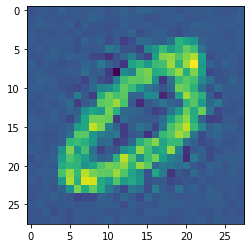

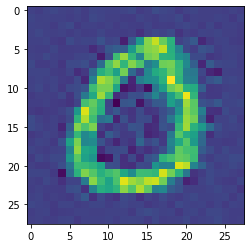

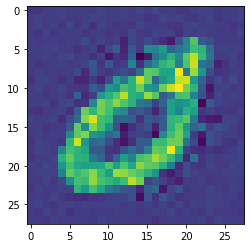

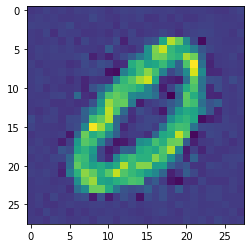

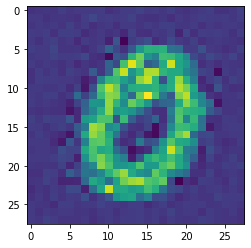

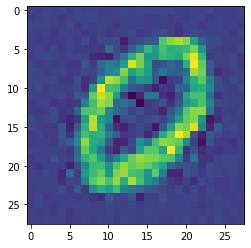

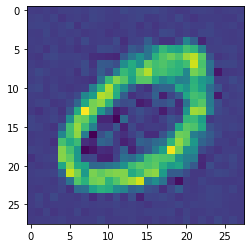

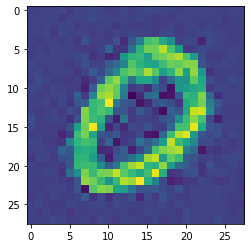

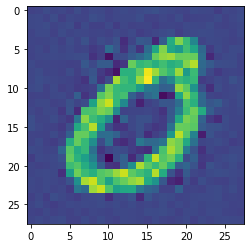

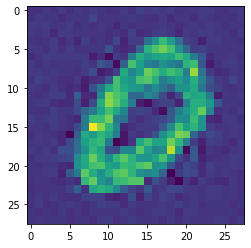

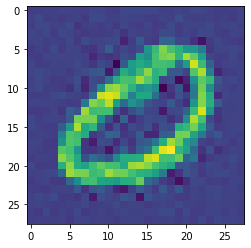

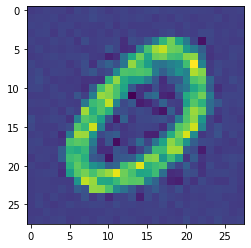

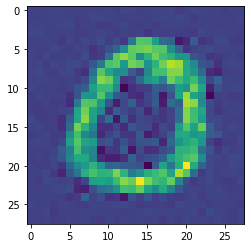

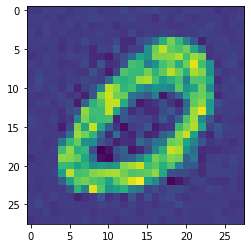

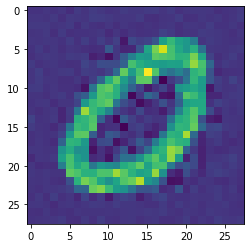

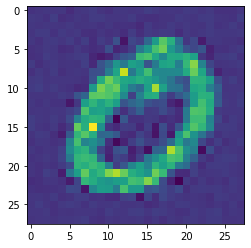

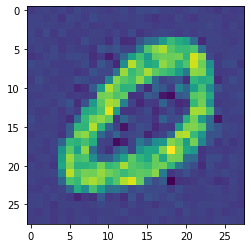

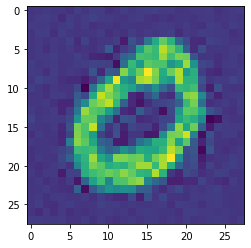

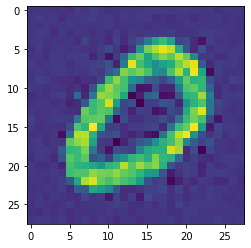

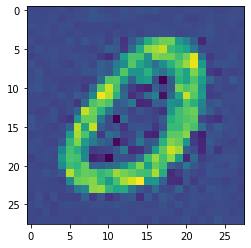

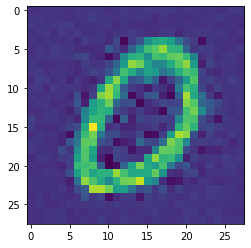

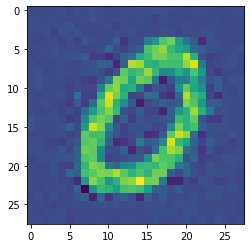

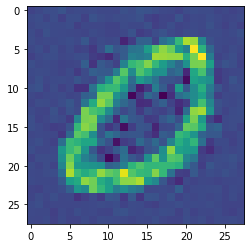

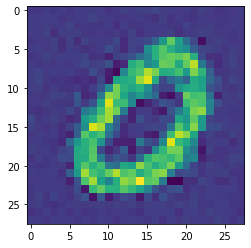

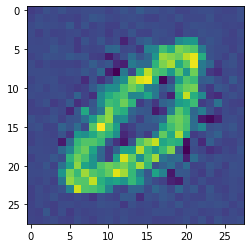

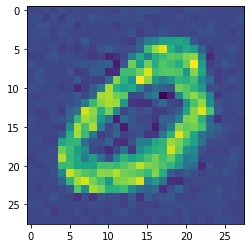

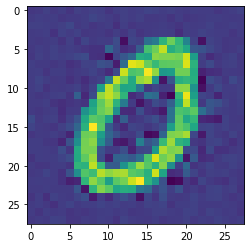

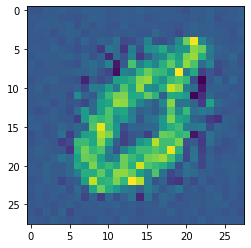

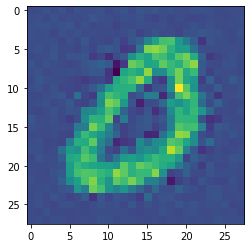

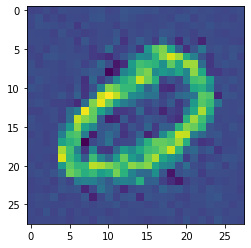

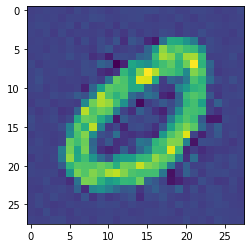

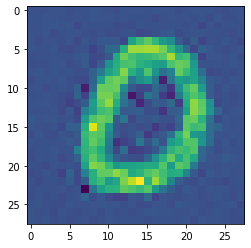

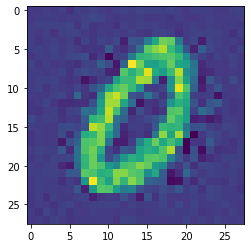

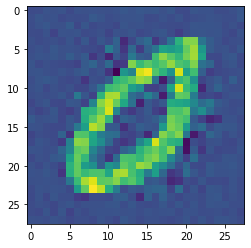

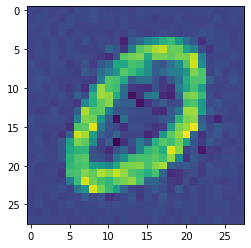

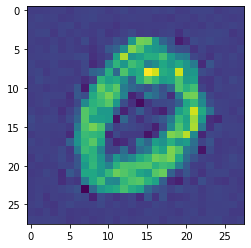

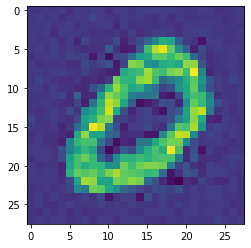

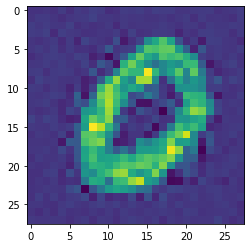

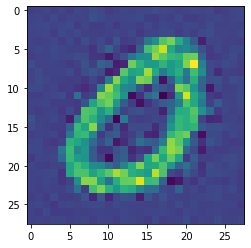

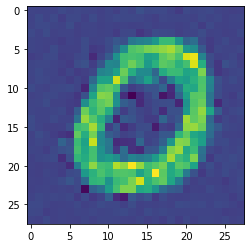

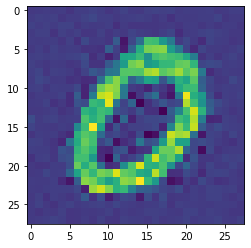

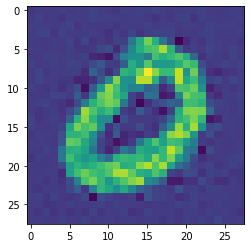

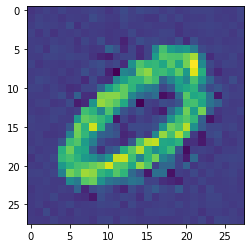

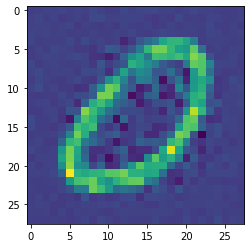

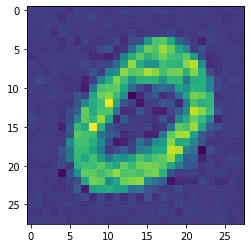

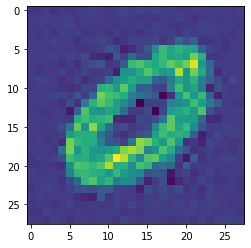

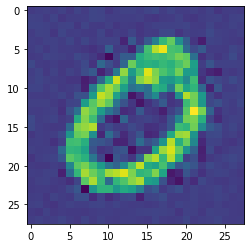

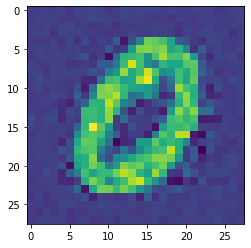

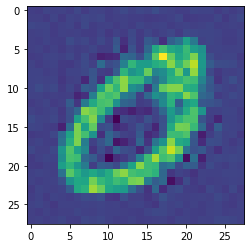

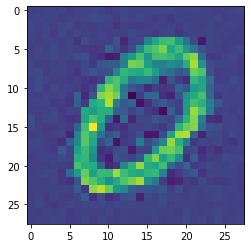

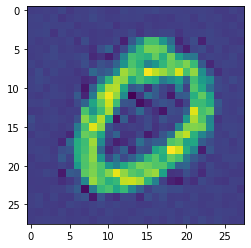

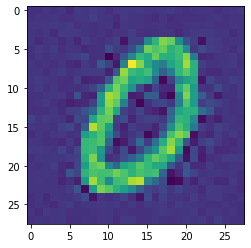

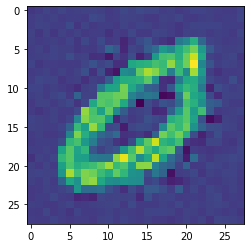

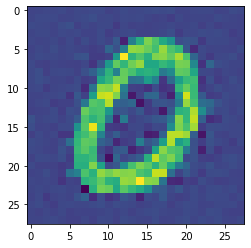

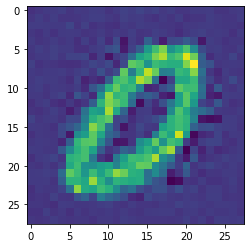

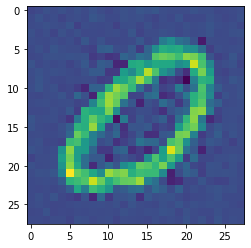

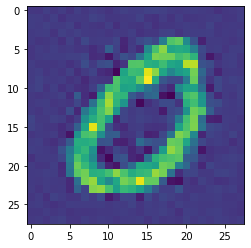

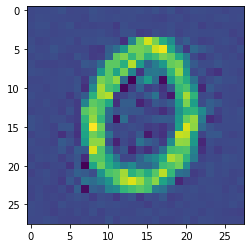

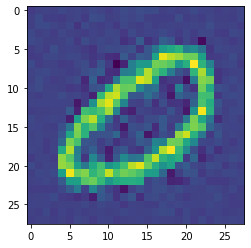

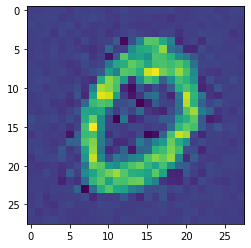

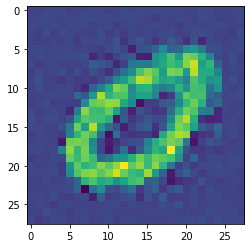

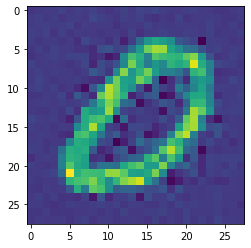

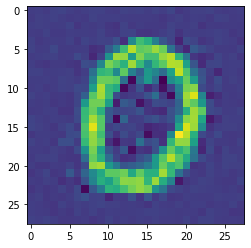

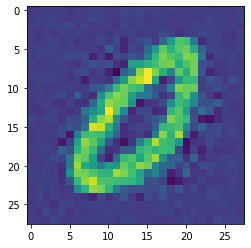

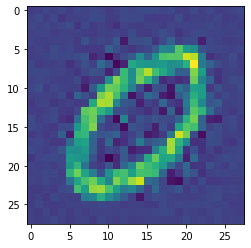

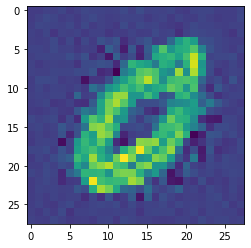

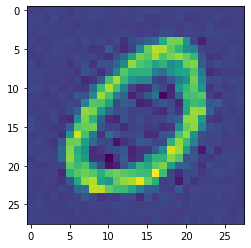

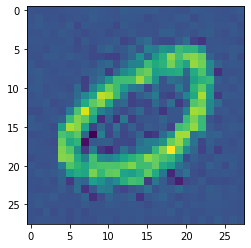

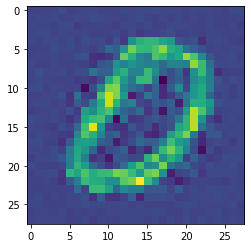

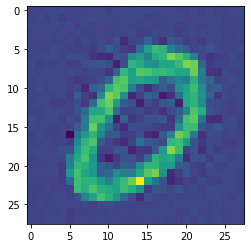

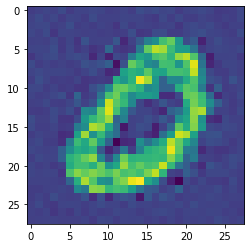

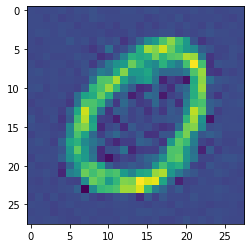

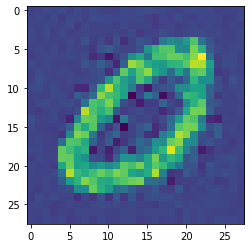

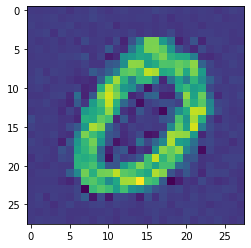

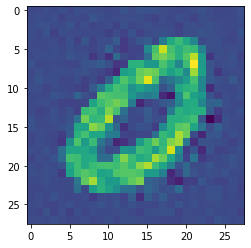

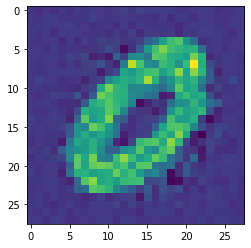

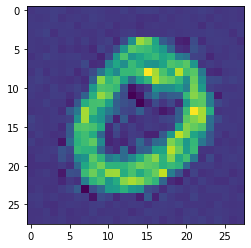

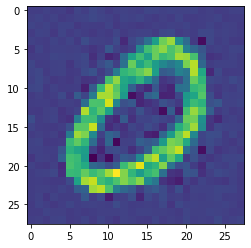

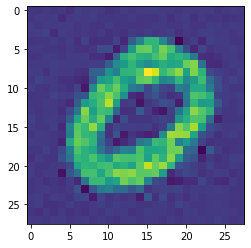

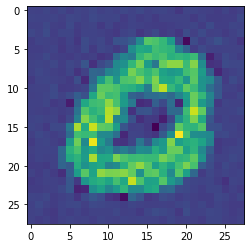

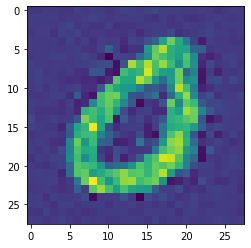

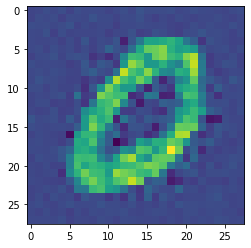

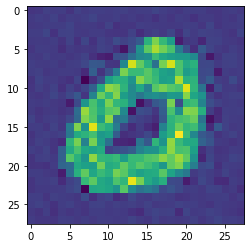

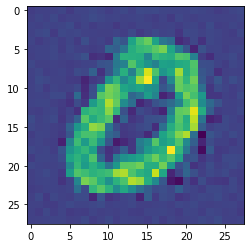

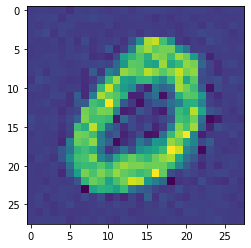

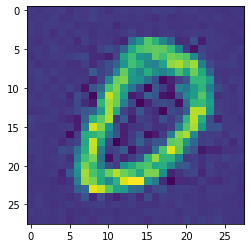

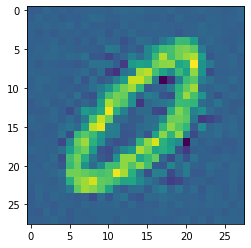

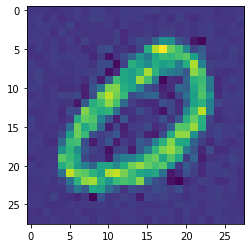

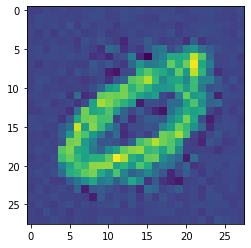

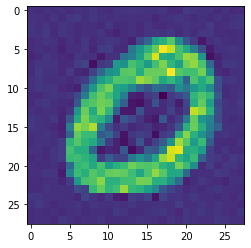

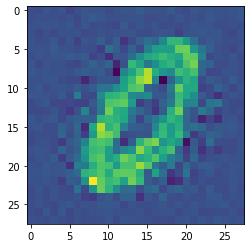

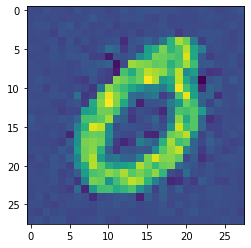

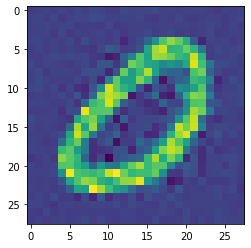

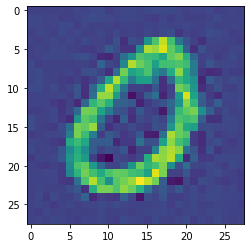

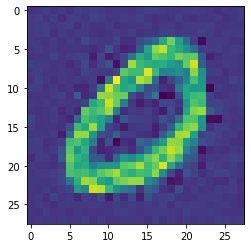

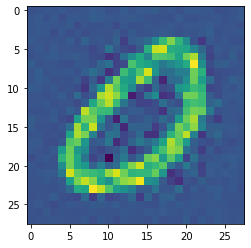

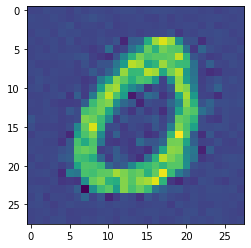

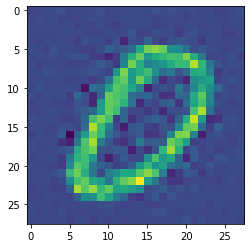

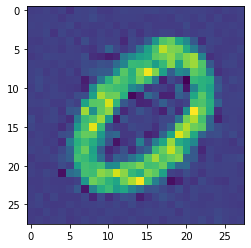

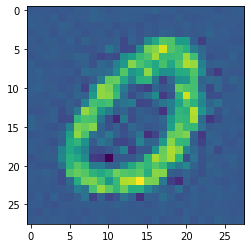

In [29]:

for w in fake_image:
    plt.imshow(w.detach().cpu().view(28,28))
    plt.show()